In [ ]:
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import math

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Script is running with GPU')
else:
  device = torch.device("cpu")
  print('Script is running WITHOUT GPU')

Script is running with GPU


In [ ]:
sents = list(np.load('OHG_sents.npy', allow_pickle=True))
tags = list(np.load('OHG_tags_minimal.npy', allow_pickle=True))

In [ ]:
for idx, sent in enumerate(sents):
  sent.insert(0, 'start')
  sent.append('stop')
  sents[idx] = sent
for idx, sent in enumerate(tags):
  sent.insert(0, 'start')
  sent.append('stop')
  tags[idx] = sent

In [ ]:
rawwords = []
for sent in sents:
  for word in sent:
    rawwords.append(word)

rawtags = []
for sequence in tags:
  for tag in sequence:
    rawtags.append(tag)

In [ ]:
allwords = list(set(rawwords))
alltags = list(set(rawtags))

In [ ]:
word_tokenizer = {word: idx+1 for idx, word in enumerate(allwords)}
word_decoder = {idx+1: word for idx, word in enumerate(allwords)}
tag_tokenizer = {tag: idx+1 for idx, tag in enumerate(alltags)}
tag_decoder = {idx+1: tag for idx, tag in enumerate(alltags)}

def tokenize(sentences, tokenizer):
  indexed_sentences = []
  for sentence in sentences:
    indexed_sentence = [tokenizer[word] for word in sentence]
    indexed_sentences.append(indexed_sentence)
  return indexed_sentences

encsents = tokenize(sents, word_tokenizer)
enctags = tokenize(tags, tag_tokenizer)

padsents, padtags = [], []

maxlen = max(len(sublist) for sublist in encsents)
for sublist in encsents:
  while len(sublist) < maxlen:
    sublist = sublist + [0]
    if len(sublist) == maxlen:
      break
    sublist = [0] + sublist
  padsents.append(sublist)
allenctags = []
maxlen = max(len(sublist) for sublist in enctags)
for sublist in enctags:
  for i in sublist:
    allenctags.append(i)
  while len(sublist) < maxlen:
    sublist = sublist + [0]
    if len(sublist) == maxlen:
      break
    sublist = [0] + sublist
  padtags.append(sublist)

In [ ]:
tag_mask = []
for seq in padtags:
  mask = [1]*len(seq)
  for idx, tag in enumerate(seq):
    if tag == tag_tokenizer['XX']:
      mask[idx] = 0
    if tag == tag_tokenizer['PUNCT']:
      mask[idx] = 0
    if tag == tag_tokenizer['start']:
      mask[idx] = 0
    if tag == tag_tokenizer['stop']:
      mask[idx] = 0
  tag_mask.append(mask)

In [ ]:
pad_tags_mask = []
for i in range(len(padtags)):
  pad_tags_mask.append([padtags[i], tag_mask[i]])

In [ ]:
X_test, X_train, y_test, y_train = train_test_split(padsents, pad_tags_mask, test_size=0.8)
X_train_tensor = torch.tensor(X_train, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
print(X_train_tensor.size())
print(y_train_tensor.size())
print(X_test_tensor.size())
print(y_test_tensor.size())

torch.Size([15083, 236])
torch.Size([15083, 2, 236])
torch.Size([3770, 236])
torch.Size([3770, 2, 236])


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

  def categorical_accuracy(self, preds, y, mask, tag_pad_idx = 0):
    max_preds = preds.argmax(dim = 1, keepdim = False)
    max_preds = max_preds*mask
    y = y*mask
    max_preds = torch.flatten(max_preds)
    y = torch.flatten(y)
    non_pad_elements = y.nonzero()
    correct = max_preds[non_pad_elements].eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

  def early_stop(self, validation_loss, patience = 3, min_delta = 0):
    if validation_loss < self.min_validation_loss:
        self.min_validation_loss = validation_loss
        self.patiencecount = 0
    elif validation_loss > (self.min_validation_loss + min_delta):
        self.patiencecount += 1
        print(f"Early stopping counter: {self.patiencecount} out of {patience}")
        if self.patiencecount >= patience:
            return True
    return False

  def fit(self, train_dl, val_dl, epochs, pad_idx = 0):
    optimizer = torch.optim.Adam(self.parameters(), lr = 0.001)

    self.patiencecount = 0
    self.min_validation_loss = float('inf')

    self.trainlosses = []
    self.vallosses = []

    self.train_accs = []
    self.val_accs = []

    counter = 0
    for epoch in range(epochs):
      for batch in train_dl:
        counter += 1
        text = batch[0]

        output = batch[1]
        output = output.transpose(0,1)
        tags = output[0]
        mask = output[1]
        optimizer.zero_grad()
        predictions = self.forward(text)
        predictions = predictions.transpose(1,2)
        loss = self.loss_fn(predictions, tags)
        loss = (loss * mask).sum() / mask.sum()
        loss.backward()
        optimizer.step()
      train_loss, train_acc = self.evaluate(train_dl)
      val_loss, val_acc = self.evaluate(val_dl)
      self.trainlosses.append(train_loss)
      self.vallosses.append(val_loss)
      self.train_accs.append(train_acc)
      self.val_accs.append(val_acc)
      if self.early_stop(val_loss):
        break
      train_acc = train_acc*100
      val_acc = val_acc*100
      print(f"Epoch [{epoch + 1}/{epochs}] - TrainLoss: {train_loss:.4f}, ValLoss: {val_loss:.4f}, TrainAcc: {train_acc:.2f},% ValAcc: {val_acc:.2f}%")

  def evaluate(self, val_dl, pad_idx = 0):
    losses = []
    accuracies = []
    with torch.no_grad():
      for batch in val_dl:
          text = batch[0]
          output = batch[1]
          output = output.transpose(0,1)
          tags = output[0]
          mask = output[1]
          predictions = self.forward(text)
          predictions = predictions.transpose(1,2)
          loss = self.loss_fn(predictions, tags)
          loss = (loss * mask).sum() / mask.sum()
          losses.append(loss)
          acc = self.categorical_accuracy(predictions, tags, mask, pad_idx)
          accuracies.append(acc)
    return torch.Tensor(losses).mean(), torch.Tensor(accuracies).mean()

In [ ]:
class OHGTagger(Model):
    def __init__(self, vocab, embeds, hidden, tagset, n_layers, dropout, criterion, pad_idx = 0):
        super().__init__()

        self.embedding = nn.Embedding(vocab, embeds, padding_idx = pad_idx, scale_grad_by_freq = True)

        self.lstm = nn.LSTM(embeds, hidden, num_layers = n_layers, bidirectional = True,
                            dropout = dropout if n_layers > 1 else 0)

        self.lin = nn.Linear(hidden * 2, tagset)

        self.dropout = nn.Dropout(dropout)

        self.loss_fn = criterion

    def forward(self, sent):
        x = self.embedding(sent)
        x, (hidden, cell) = self.lstm(x)
        x = self.lin(self.dropout(x))
        return x

In [ ]:
vocab = len(allwords)+1
n_emb = 300
n_hidden = 60
n_tags = len(alltags)+1
n_layers = 3
dropout = .2
pad_idx = 0
criterion = nn.CrossEntropyLoss(reduction = 'none', ignore_index = pad_idx).to(device)

In [ ]:
network_OHGTagger = OHGTagger(vocab, n_emb, n_hidden, n_tags, n_layers, dropout, criterion, pad_idx).to(device)

In [ ]:
%time network_OHGTagger.fit(train_loader, test_loader, 50)

Epoch [1/50] - TrainLoss: 0.0306, ValLoss: 0.0330, TrainAcc: 70.06,% ValAcc: 68.16%
Epoch [2/50] - TrainLoss: 0.0201, ValLoss: 0.0254, TrainAcc: 81.02,% ValAcc: 75.88%
Epoch [3/50] - TrainLoss: 0.0144, ValLoss: 0.0237, TrainAcc: 86.66,% ValAcc: 78.59%
Early stopping counter: 1 out of 3
Epoch [4/50] - TrainLoss: 0.0109, ValLoss: 0.0237, TrainAcc: 90.06,% ValAcc: 79.92%
Early stopping counter: 2 out of 3
Epoch [5/50] - TrainLoss: 0.0089, ValLoss: 0.0248, TrainAcc: 91.71,% ValAcc: 80.57%
Early stopping counter: 3 out of 3
CPU times: user 30.4 s, sys: 4.62 s, total: 35 s
Wall time: 42.3 s


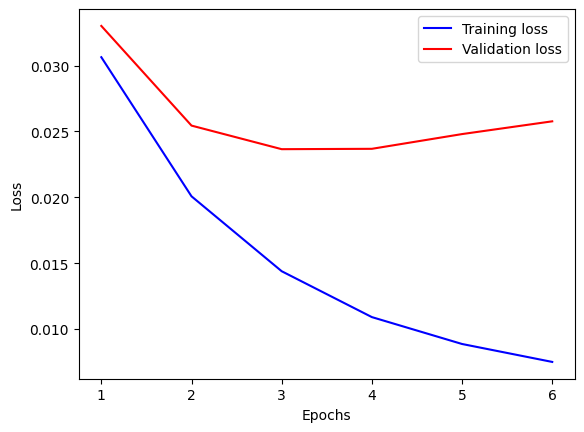

In [ ]:
epochs = range(1, len(network_OHGTagger.trainlosses) + 1)

plt.plot(epochs, network_OHGTagger.trainlosses, 'blue', label='Training loss')
plt.plot(epochs, network_OHGTagger.vallosses, 'red', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

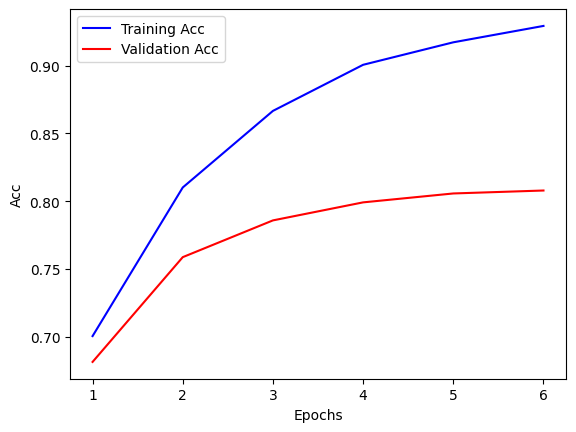

In [ ]:
epochs = range(1, len(network_OHGTagger.train_accs) + 1)

plt.plot(epochs, network_OHGTagger.train_accs, 'blue', label='Training Acc')
plt.plot(epochs, network_OHGTagger.val_accs, 'red', label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
def predict(model, data, pad_idx):
    with torch.no_grad():
      predicts_out = []
      tags_out = []
      text_out = []
      for batch in data:
        text = batch[0]
        output = batch[1]
        output = output.transpose(0,1)
        tags = output[0]
        mask = output[1]
        predictions = model.forward(text)
        predictions = predictions.transpose(1,2)
        predictions = predictions.argmax(dim = 1)
        for idx, sent in enumerate(text):
          predicts_out.append(np.array(predictions[idx].cpu()))
          tags_out.append(np.array(tags[idx].cpu()))
          text_out.append(np.array(sent.cpu()))
    for idx, ele in enumerate(predicts_out):
      predicts_out[idx] = predicts_out[idx].tolist()
    for idx, ele in enumerate(tags_out):
      tags_out[idx] = tags_out[idx].tolist()
    for idx, ele in enumerate(text_out):
      text_out[idx] = text_out[idx].tolist()

    return predicts_out, tags_out, text_out

In [ ]:
preds, tags, texts = predict(network_OHGTagger, test_loader, pad_idx)

In [ ]:
for i in range(len(preds)):
  for j in range(len(preds[i])):
    if tags[i][j] == 0:
      preds[i][j] = 0
  preds[i] = [ele for ele in preds[i] if ele != 0]
  tags[i] = [ele for ele in tags[i] if ele != 0]
  texts[i] = [ele for ele in texts[i] if ele != 0]

In [ ]:
decpreds, dectags, dectext, declangs = [], [], [], []
decpreds.append(tokenize(preds, tag_decoder))
dectags.append(tokenize(tags, tag_decoder))
dectext.append(tokenize(texts, word_decoder))
decpreds = decpreds[0]
dectags = dectags[0]
dectext = dectext[0]

In [ ]:
print(decpreds[0])
print(dectags[0])
print(dectext[0])

['VB', 'CONJ', 'D', 'VB', 'ADJ', 'VB']
['start', 'CONJ', 'D', 'ADJ', 'PUNCT', 'stop']
['start', 'únde', 'dén', 'snéllen', '.', 'stop']


In [ ]:
corrects, incorrects, totals = [], [], []
for i in range(len(decpreds)):
  for j in range(len(decpreds[i])):
    totals.append(dectags[i][j])
    if decpreds[i][j] == dectags[i][j]:
      corrects.append(decpreds[i][j])
    else:
      incorrects.append(decpreds[i][j])


c_freqs = Counter(corrects)
ic_freqs = Counter(incorrects)
t_freqs = Counter(totals)


print('Total Accuracy:')
data = []
labels = []
any_c = [x[0] for x in c_freqs.most_common()]
for i in t_freqs.most_common():
  if i[0] not in any_c:
    data.append(0)
    labels.append(i[0])
    print(f'{i[0]} | 0% of {i[1]}')
  else:
    for ele in c_freqs.most_common():
      if ele[0] == i[0]:
        num_c = ele[1]
    class_acc = num_c/i[1]
    data.append(class_acc*100)
    labels.append(i[0])
    print(f'{i[0]} | {class_acc*100:.2f}% of {i[1]}')

Total Accuracy:
VB | 77.89% of 6937
PUNCT | 0% of 6274
N | 76.72% of 5636
PRO | 91.89% of 4094
D | 94.09% of 3961
start | 0% of 3770
stop | 0% of 3770
ADV | 78.53% of 3507
CONJ | 72.92% of 2548
AP | 92.82% of 2144
ADJ | 50.23% of 1730
WH | 74.83% of 894
PART | 95.77% of 568
NUM | 49.66% of 147
INTJ | 33.33% of 36
XX | 0% of 4


In [ ]:
plot_list = ['VB', 'PRO', 'D', 'ADV', 'CONJ', 'AP', 'ADJ', 'WH', 'PART', 'N', 'NUM', 'INTJ']

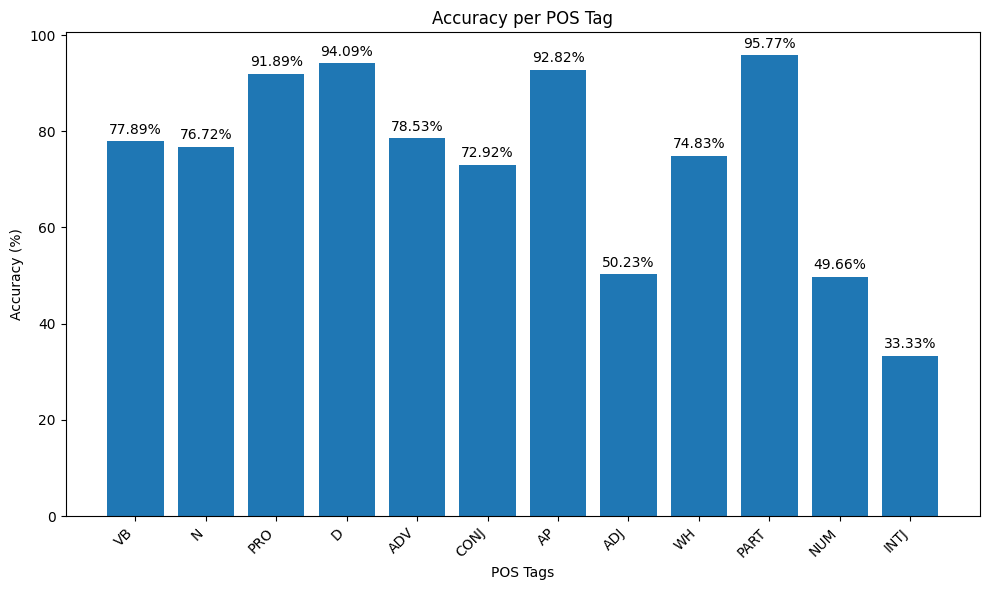

In [ ]:
plot_data = []
plot_labels = []
for label, value in zip(labels, data):
    if label in plot_list:
        plot_data.append(value)
        plot_labels.append(label)

plt.figure(figsize=(10, 6))
plt.bar(plot_labels, plot_data)
plt.xlabel("POS Tags")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per POS Tag")
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(plot_data):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()
